In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance

In [12]:
def load_data(filepath):
    """Load dataset and show basic info."""
    df = pd.read_csv(filepath)
    print(df.info())
    print(df.describe())
    return df

def plot_missing_values(df):
    """Visualize missing values in the dataset."""
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.show()

def plot_target_distribution(df, target='SalePrice'):
    """Plot the distribution of target variable."""
    sns.histplot(df[target], kde=True)
    plt.show()

def ordinal_encode(df, mappings):
    """Map ordinal categorical features to numeric."""
    for col, mapping in mappings.items():
        df[col] = df[col].map(mapping).fillna(0)
    return df

def one_hot_encode(df, drop_first=True):
    """One-hot encode categorical variables."""
    categorical_cols = df.select_dtypes(include=['object']).columns
    return pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first)

def select_top_features(df, target='SalePrice', threshold=0.3):
    """Select features with correlation above threshold."""
    corr = df.corr()[target]
    top_corr_features = corr[abs(corr) >= threshold]
    features = list(top_corr_features.index)
    if target not in features:
        features.append(target)
    return df[features]

def fill_missing(df, col_medians={}, col_defaults={}):
    """Fill missing numeric values."""
    for col, val in col_medians.items():
        df[col].fillna(val, inplace=True)
    for col, val in col_defaults.items():
        df[col].fillna(val, inplace=True)
    return df

def remove_outliers(df, col, method='max'):
    """Remove outlier row based on a column."""
    if method == 'max':
        idx = df[col].idxmax()
    elif method == 'min':
        idx = df[col].idxmin()
    df = df.drop(index=idx).reset_index(drop=True)
    return df, idx

def plot_feature_importance(model, max_features=20):
    """Plot XGBoost feature importance."""
    plt.figure(figsize=(10,8))
    plot_importance(model, max_num_features=max_features, importance_type='weight')
    plt.show()

def train_xgboost(X_train, y_train, X_test, y_test, params=None):
    """Train XGBoost and return model and RMSE."""
    if params is None:
        params = {
            'n_estimators':300,
            'learning_rate':0.05,
            'max_depth':3,
            'subsample':0.6,
            'colsample_bytree':0.8,
            'random_state':42
        }
    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        early_stopping_rounds=50,
        eval_set=[(X_test, y_test)],
        verbose=50
    )
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE on test set: {rmse:.2f}")
    return model, rmse

# ==============================
# Full EDA Functions
# ==============================

def basic_info(df):
    """Show basic info and descriptive statistics."""
    print("INFO:")
    print(df.info())
    print("\nDESCRIBE:")
    print(df.describe())

def missing_values(df):
    """Return a Series with missing value counts."""
    missing = df.isnull().sum().sort_values(ascending=False)
    print("Top 10 Missing Values:")
    print(missing.head(10))
    return missing

def plot_missing(df):
    """Heatmap of missing values."""
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title("Missing Values Heatmap")
    plt.show()

def plot_target(df, target='SalePrice'):
    """Histogram of the target variable."""
    plt.figure(figsize=(8,6))
    sns.histplot(df[target], kde=True)
    plt.title(f"{target} Distribution")
    plt.show()

def plot_boxplots(df, numeric_cols):
    """Boxplots for numeric features to check outliers."""
    plt.figure(figsize=(15,6))
    sns.boxplot(data=df[numeric_cols].sample(min(10, len(numeric_cols))))  # show max 10 cols for readability
    plt.xticks(rotation=45)
    plt.title("Boxplots of numeric features")
    plt.show()

def scatter_numeric_vs_target(df, features, target='SalePrice'):
    """Scatter plots of important numeric features vs target."""
    plt.figure(figsize=(12,8))
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 2, i)
        sns.scatterplot(data=df, x=feature, y=target)
        plt.title(f"{feature} vs {target}")
    plt.tight_layout()
    plt.show()

def correlation_heatmap(df, target='SalePrice'):
    """Plot correlation heatmap and return correlation Series with target."""
    corr = df.corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', annot=False)
    plt.title("Correlation Heatmap")
    plt.show()
    
    # Correlation with target
    corr_target = corr[target].sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")
    plt.title(f"Features Correlated with {target}")
    plt.xlabel("Correlation")
    plt.show()
    
    return corr_target

def top_correlated_features(df, target='SalePrice', threshold=0.3):
    """Return features with absolute correlation above threshold."""
    corr_target = df.corr()[target]
    top_features = corr_target[abs(corr_target) >= threshold].sort_values(ascending=False)
    print(f"Top features with correlation >= {threshold}:")
    print(top_features)
    return top_features

def categorical_summary(df):
    """Print count of unique categories for each categorical column."""
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        print(f"{col}: {df[col].nunique()} unique values")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

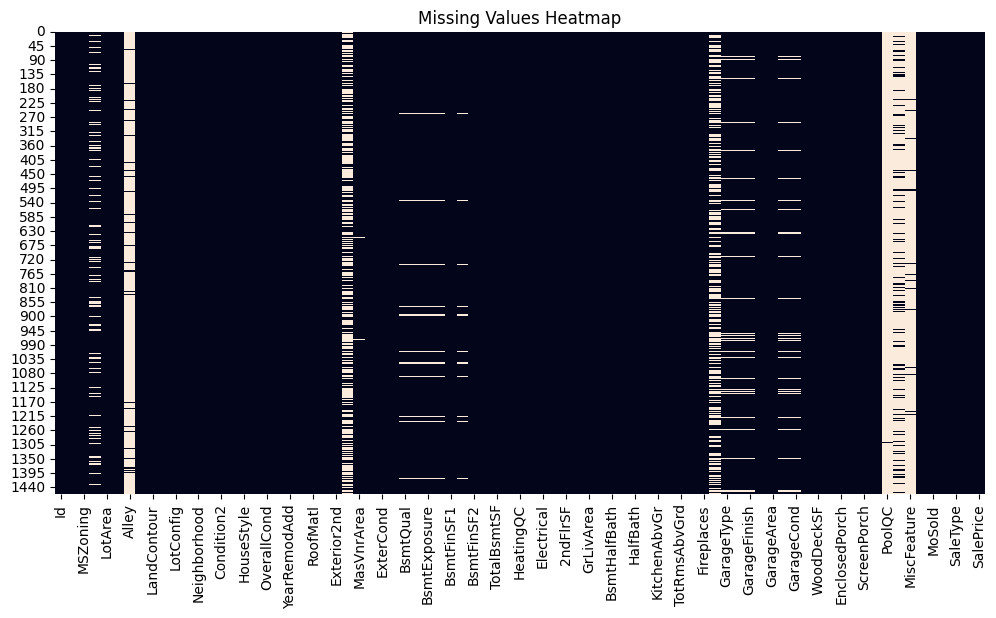

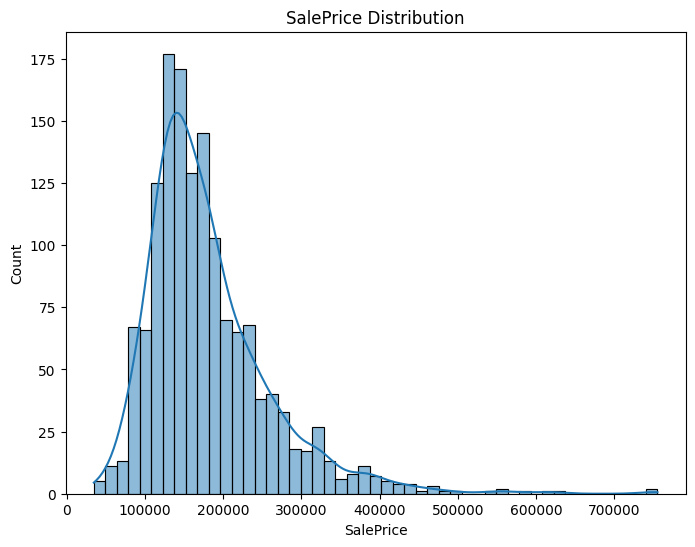

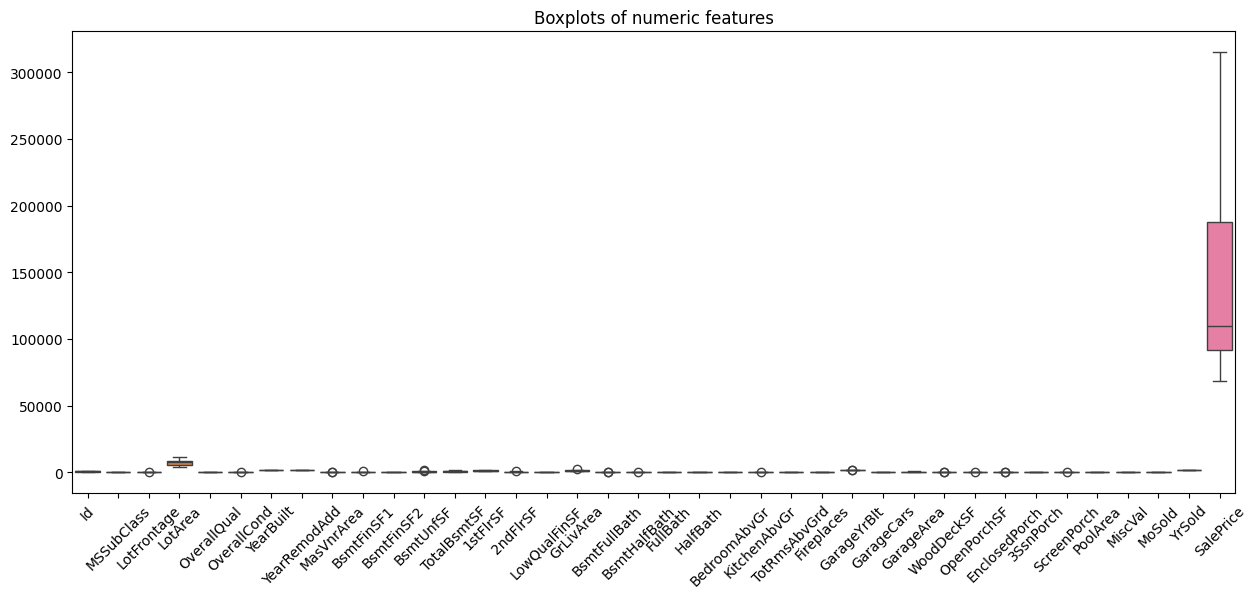

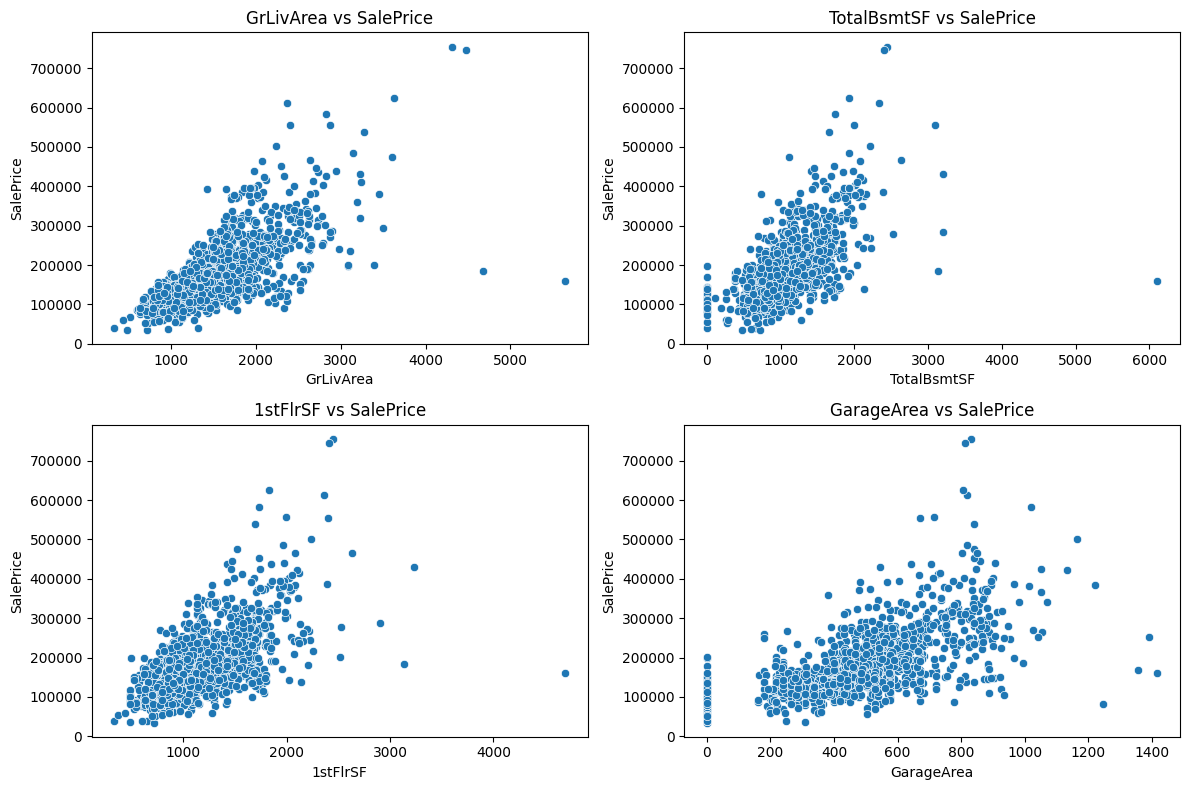

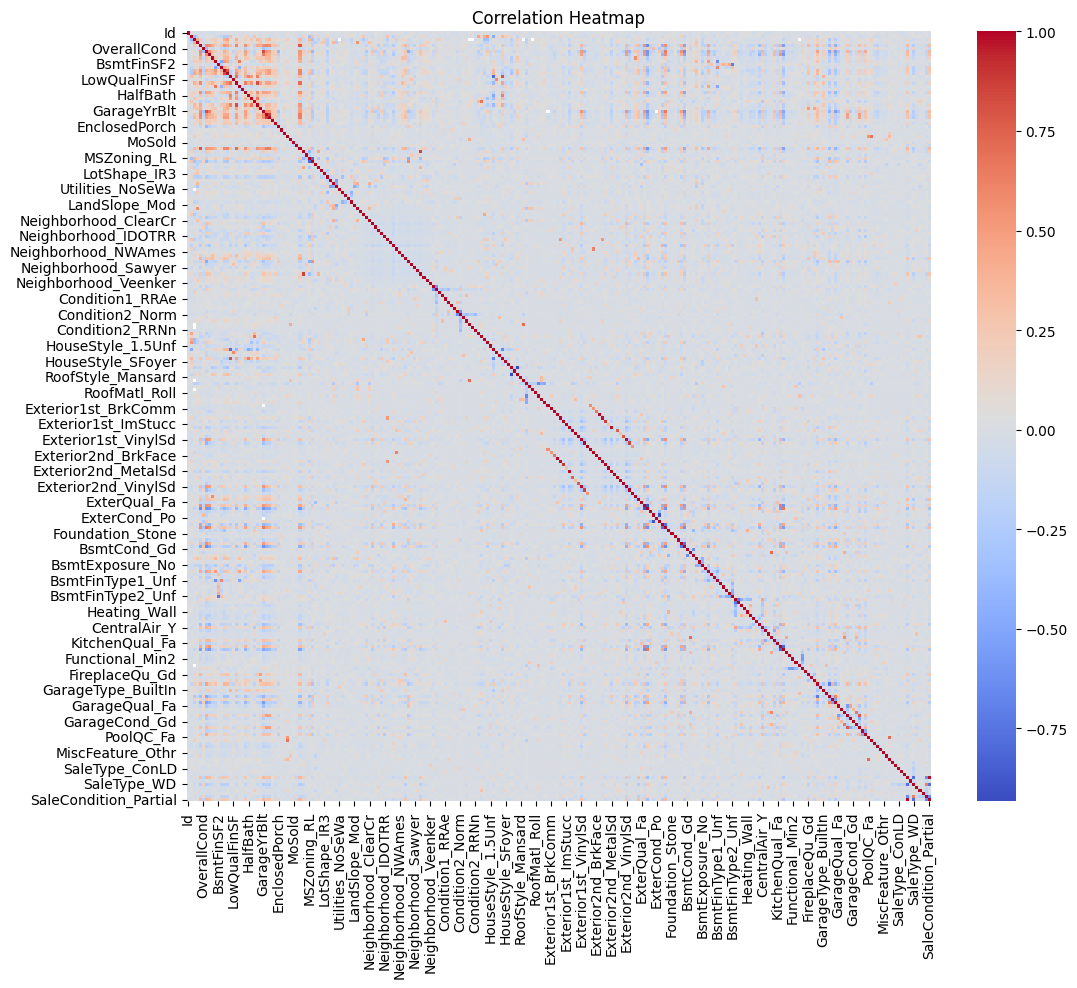

/var/folders/40/h3m4kk3n3kx9r7bn1_4_nwmm0000gn/T/ipykernel_38844/2177106546.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")


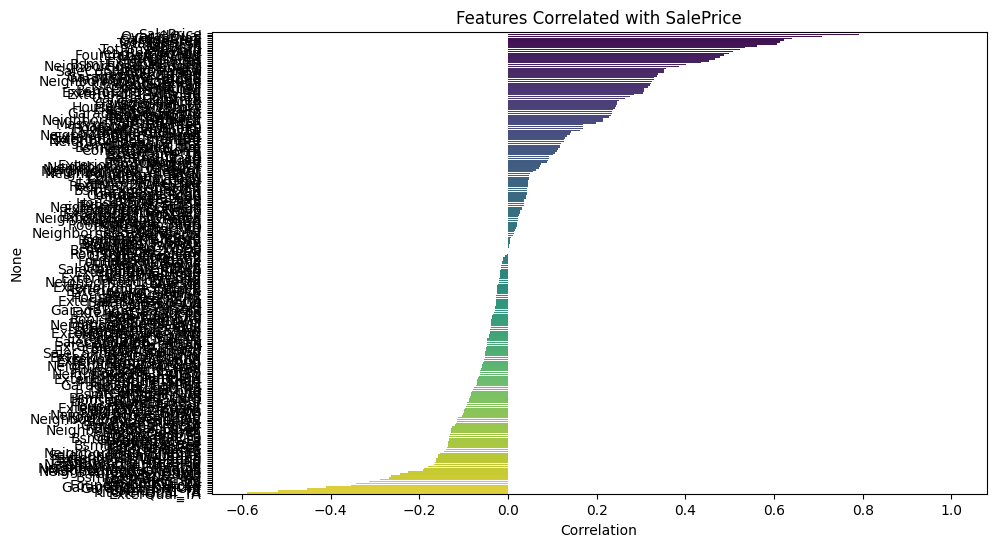

Top features with correlation >= 0.3:
SalePrice                1.000000
OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
FullBath                 0.560664
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
YearRemodAdd             0.507101
Foundation_PConc         0.497734
GarageYrBlt              0.486362
MasVnrArea               0.477493
Fireplaces               0.466929
ExterQual_Gd             0.452466
BsmtFinType1_GLQ         0.434597
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
SaleType_New             0.357509
SaleCondition_Partial    0.352060
LotFrontage              0.351799
FireplaceQu_Gd           0.339329
GarageType_Attchd        0.335961
MasVnrType_Stone         0.330476
Neighborhood_NoRidge     0.330424
WoodDeckSF               0.324413
KitchenQual_Gd           0.321641
2ndFlrSF  

In [13]:
#EDA

# Load dataset
df = load_data(r"data/train.csv")

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Basic info & missing values
basic_info(df)
missing_values(df)
plot_missing(df)

# Target distribution
plot_target(df, 'SalePrice')

# Boxplots & scatter plots
plot_boxplots(df, numeric_cols)
scatter_numeric_vs_target(df, ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea'])

df_numeric = pd.get_dummies(df, drop_first=True)  # convert all strings to numeric

# Now you can safely compute correlations
corr_target = correlation_heatmap(df_numeric, 'SalePrice')
top_features = top_correlated_features(df_numeric, 'SalePrice', threshold=0.3)

# Categorical summary
categorical_summary(df)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

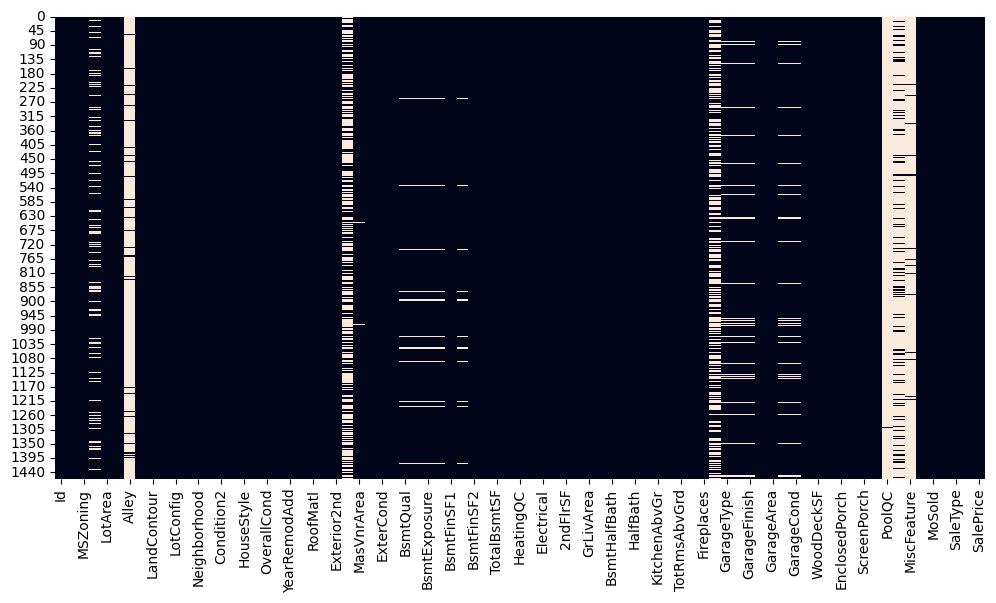

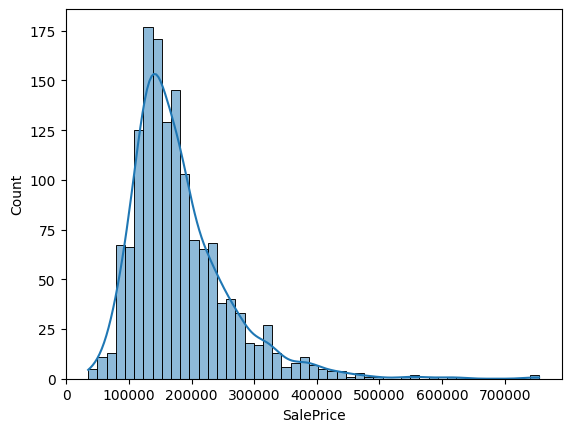

[0]	validation_0-rmse:72160.21467
[50]	validation_0-rmse:26598.17538
[100]	validation_0-rmse:24331.51780
[150]	validation_0-rmse:24447.92032
RMSE on test set: 24311.41


/var/folders/40/h3m4kk3n3kx9r7bn1_4_nwmm0000gn/T/ipykernel_38844/2177106546.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(val, inplace=True)
/var/folders/40/h3m4kk3n3kx9r7bn1_4_nwmm0000gn/T/ipykernel_38844/2177106546.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(val, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

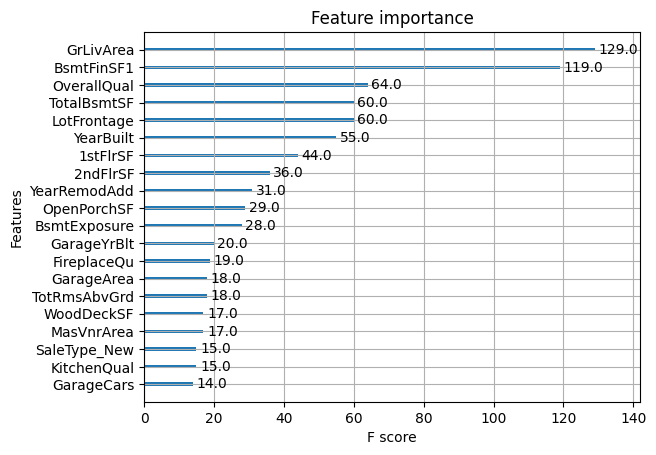

In [14]:
#modeling

df = load_data(r"data/train.csv")

# Visualizations
plot_missing_values(df)
plot_target_distribution(df, 'SalePrice')

# Ordinal encoding
ordinal_mappings = {
    'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'FireplaceQu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'PoolQC': {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
    'BsmtExposure': {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
    'GarageFinish': {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3},
}
df = ordinal_encode(df, ordinal_mappings)

# One-hot encoding
df_encoded = one_hot_encode(df)

# Select top features
df_selected = select_top_features(df_encoded, 'SalePrice', threshold=0.3)

# Fill missing values
df_selected = fill_missing(
    df_selected,
    col_medians={'LotFrontage': df_encoded["LotFrontage"].median()},
    col_defaults={'GarageYrBlt': 0, 'MasVnrArea':0}
)

# Remove GrLivArea outlier
df_selected, outlier_idx = remove_outliers(df_selected, 'GrLivArea', 'max')

# Train/test split
X = df_selected.drop('SalePrice', axis=1)
y = df_selected['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
xgb_model, rmse = train_xgboost(X_train, y_train, X_test, y_test)

# Feature importance
plot_feature_importance(xgb_model)

In [15]:
# ==============================
# Kaggle Submission Pipeline
# ==============================

# 1️⃣ Load test data
test_df = load_data("data/test.csv")

# 2️⃣ Apply ordinal mappings (use the same as train)
ordinal_mappings = {
    'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'BsmtCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'FireplaceQu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'GarageCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
    'PoolQC': {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},
    'BsmtExposure': {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
    'GarageFinish': {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3},
}

test_df = ordinal_encode(test_df, ordinal_mappings)

# 3️⃣ Fill missing numeric values (same as train)
col_medians = {
    "LotFrontage": df_selected["LotFrontage"].median()
}
col_defaults = {
    "GarageYrBlt": 0,
    "MasVnrArea": 0
}

test_df = fill_missing(test_df, col_medians, col_defaults)

# 4️⃣ One-hot encode
test_df_encoded = one_hot_encode(test_df, drop_first=True)

# 5️⃣ Align columns with training features
train_features = df_selected.drop("SalePrice", axis=1).columns
for col in train_features:
    if col not in test_df_encoded.columns:
        test_df_encoded[col] = 0

# Reorder columns to match training
test_df_encoded = test_df_encoded[train_features]

# 6️⃣ Predict with trained XGBoost model
y_pred = xgb_model.predict(test_df_encoded)

# 7️⃣ If you trained with log1p transform:
# y_pred = np.expm1(y_pred)

# 8️⃣ Create submission file
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": y_pred
})

submission.to_csv("submission.csv", index=False)
print("submission.csv created successfully!")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC